In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotnine as gg
import umap
from pathlib import Path
import scipy.linalg
from sklearn.feature_selection import VarianceThreshold
from functions import whitening_transform

In [16]:
top_dir = os.path.dirname(os.getcwd())
proj_dir = 'data'
outpath = os.path.join(top_dir, "Figures")

In [17]:
class load_data:
    
    
    def __init__(self,top_dir,proj_dir):
        
        self.top_dir = top_dir
        self.proj_dir = proj_dir
    
    
    def csvpath(self):
        path = os.path.join(self.top_dir, self.proj_dir, "backend")
        plates = [pl for pl in os.listdir(path)]
        csvpath = [os.path.join(path, pl, pl + "_dmso.csv") for pl in plates]  
        
        return csvpath

    
    def featlist(self):
        path = os.path.join(self.top_dir, self.proj_dir,"metadata","input", "feature_list_reduced.txt")
        featlist = np.loadtxt(str(path), dtype=str).tolist()
        return featlist

    
    
    
    
subclass = load_data(top_dir, proj_dir)

csvlist = subclass.csvpath()

featlist = subclass.featlist()




csvlist

len(featlist)

471

## Data Preprocessing

In [21]:
def processing_data(csvlist, featlist, outdata):
    
    """
    Implements the combining CSV's, zscoring, whitening and umap
    
    Arguments:
    
    csvlist -- input list of dataset path
    
    featlist -- list of pre-selected features
    
    outdata -- returns output data
    
    parameters:
                "combined" -- returns z-normalized combined CSV's profiles
                "combined+umap" -- returns umap of z-normalized combined CSV's profiles
                "combined+whitened" -- returns whitened z-normalized combined CSV's profiles
                "combined+whitened+umap" -- returns umap of whitened z-normalized combined CSV's profiles
                    
                       
    
    Returns:
    
    outdata  -- combined DataFrame
    
    """
    
    
    combined = []
    
    for csv in csvlist:
        
        metadata = ['Image_FileName_OrigMito', 'Image_FileName_OrigER', 'Image_PathName_OrigER', 
                    'Metadata_mg_per_ml','Image_PathName_OrigDNA','Image_PathName_OrigRNA',
                    'Image_PathName_OrigMito','Image_FileName_OrigDNA','Image_FileName_OrigRNA',
                    'Metadata_broad_sample','Image_Metadata_Well','Metadata_plate_map_name',
                    'Metadata_mmoles_per_liter','Image_FileName_CellOutlines','Image_Metadata_Site',
                    'Metadata_Plate','Image_FileName_OrigAGP','Image_PathName_CellOutlines',
                    'Image_PathName_OrigAGP','Cells_Location_Center_X','Cells_Location_Center_Y',
                    'Nuclei_Location_Center_X','Nuclei_Location_Center_Y','Cytoplasm_Location_Center_X', 
                    'Cytoplasm_Location_Center_Y','ObjectNumber']
        
    
        dmso = pd.read_csv(csv)
        
        scale = StandardScaler()
        
        scaled_data = scale.fit_transform(dmso[featlist].values)
        
         
        
        
        if outdata == "combined":
            
             
            df = dmso[metadata].merge(pd.DataFrame(scaled_data, columns=featlist), 
                                            how='left',
                                            left_index=True,
                                            right_index=True
                                           )
            
            combined.append(df)
            
            
            
            
        elif outdata == "combined+umap":
            
            
            reducer = umap.UMAP(random_state=0)
        
            embedding = reducer.fit_transform(scaled_data)
        
            test = pd.DataFrame(embedding, columns= ['UMAP-1', 'UMAP-2'])
            
            df = dmso[metadata].merge(test, how='left',
                                            left_index=True,
                                            right_index=True)
            

            combined.append(df)
            
            
        elif outdata == "combined+whitened":
            

        ## Applying whitening transformation on Z normalized features
            
            wh = whitening_transform(scaled_data, 'ZCA')
            wh_profile = wh.whiten()
    
             
            df = dmso[metadata].merge(pd.DataFrame(wh_profile, columns=featlist), 
                                            how='left',
                                            left_index=True,
                                            right_index=True
                                           )
            
            
            combined.append(df)
            
            
        elif outdata == "combined+whitened+umap":
        
    
            wh = whitening_transform(scaled_data, 'ZCA')
            
            wh_profile = wh.whiten()
         
            reducer = umap.UMAP(random_state=10)
        
            embedding = reducer.fit_transform(wh_profile)
        
            test = pd.DataFrame(embedding, columns= ['UMAP-1', 'UMAP-2'])
            
            df = dmso[metadata].merge(test, how='left',
                                            left_index=True,
                                            right_index=True)
            
            
            combined.append(df)
        
    
    return pd.concat(combined)



df_whitened = processing_data(csvlist, featlist, outdata="combined+whitened")

df_whitened_umap_scaled = processing_data(csvlist, featlist, outdata="combined+whitened+umap")

In [22]:
df_whitened.to_csv("/Users/habbasi/Documents/Github/broadinstitute/2020-06-01-Evidence-of-state-switching-in-single-cell-drug-response-Broad/data/umap_data/dmso_notscaled_ZCA_whitened.csv")

In [20]:
def plotting_function(data, title, filename, outpath):
    
    p = gg.ggplot(data, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Plate')) + \
    gg.geom_point(size = 0.003) + \
    gg.xlab("UMAP-1") + \
    gg.ylab("UMAP-2") + \
    gg.ggtitle(title) + \
    gg.theme_bw() + \
    gg.scale_colour_manual(name= "Platemap", labels=['SQ00015201', 'SQ00015142', 'SQ00015143', 'SQ00015144', 'SQ00015145'], 
                           values = ["#d95f0e", "#fec44f", "#2c7fb8", "#7fcdbb", '#636363'])

   
    gg.ggsave(filename=filename, plot = p, path = outpath)

    
    return p
    
    
    
    
    

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/2020-06-01-Evidence-of-state-switching-in-single-cell-drug-response-Broad/Figures/UMAP_DMSO-whitened_cellprofiles_new_scaled_Juanwhitenening_randomstate_10_reduced_features_rotationfalse.png


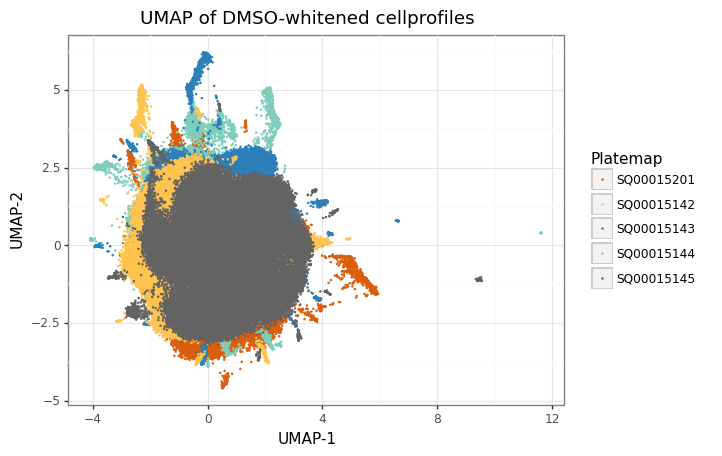

<ggplot: (7027671245)>

In [13]:
plotting_function(df_whitened_umap_scaled, "UMAP of DMSO-whitened cellprofiles", "UMAP_DMSO-whitened_cellprofiles_new_scaled_Juanwhitenening_randomstate_10_reduced_features_rotationfalse.png", outpath)